Here we use ALP a secondary photon spectrum to produce an ALP event same via the Primakoff mechanism 
$$ \gamma N \to a N $$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import copy
from multiprocessing import Pool
from functools import partial
import tqdm
import time
from scipy import integrate

from scipy.interpolate import interp2d, griddata, interp1d


from mc import *
from lhe_output import create_LHE_file

def alp_width(ma, gag):
    """
    ALP decay width; ma = ALP mass, gag = ALP coupling to photons, defined by the interaction-gag/4 ALP F Ftilde
    """
    return ma**3 * gag**2 / (64. * np.pi)


def get_t_integral(ma, mN, A, Z, Egamma):
    s = s_term(mN,Egamma)
    if s <  (ma+mN)**2:
        return np.zeros(2)
    t1, t0 = t_bounds(ma, mN, Egamma)

    # the integrand is peaked near t0
    # choose a new lower bound on the integral that is not super far from the peak to avoid
    # integration issues
    # the factor 100000 is chosen by hand, and found to give a stable estimate without numerical errrors
    t1_approx = max(t1,100000.*t0)
    sigma, error = integrate.quad(t_distribution, t1_approx, t0, args = (ma, mN, A, Z, Egamma))
    #print(sigma,"\t",error)
    
    return np.array([sigma, error])


def direct_production_cross_section(N_mcpN, photons, ma, mN, A, Z):
    """
    Nmc is number of electron-target collisions simulated
    photons is an array of photon 4 vectors from all of those collisisons
    
    returns cross-section in cm^2
    """
    gag = 1. # 1/GeV
    aEM = 1/137.
    hbarc = 0.1973269804 *1e-13 #cm * GeV
    
    r  = 0.
  
    Egamma_list = photons[:,0]

    # Use some fraction of available CPU cores
    pool = Pool(int(os.cpu_count()/2))
    # partial can be used to specify function arguments that are common for all instances
    # if there are no such arguments you dont need to wrap in partial
    sigma_list = pool.map(partial(get_t_integral, ma, mN, A, Z), Egamma_list)
    pool.close()
    sigma_list = np.array(sigma_list)

        
    r = np.sum(sigma_list[:,0])/N_mcpN
    err = np.sum(sigma_list[:,1])/N_mcpN
    
    
    # this factor was taken out of sigma_gamma N to defined t_distribution
    sigma_coef = gag**2 * aEM * Z**2 / 8.
    result = {}
    result['sigma'] = sigma_coef * r * (hbarc)**2 #* n*T_g * sigma_pN
    result['error'] = sigma_coef * err * (hbarc)**2 #* n*T_g * sigma_pN
    return result

def bootstrap_sample(data, Nboots):
    rng = np.random.default_rng()
    
    boostrapped_data = data[rng.integers(0, data.shape[0], size=Nboots)]
    
    return boostrapped_data

In [2]:
ldmx_photons = np.loadtxt('../data_from_sophie.csv',delimiter=',')[:,1:] / 1000. # convert MeV to GeV
len(ldmx_photons)

57242

In [22]:
ldmx_photons[np.random.randint(0,ldmx_photons.shape[0],size=10)]

array([[ 3.68291348e-04,  1.65700912e-04,  5.67990281e-05,
        -3.23968500e-04],
       [ 2.40511715e-04,  1.09654732e-04, -1.86852589e-05,
        -2.13243023e-04],
       [ 9.63616490e-04,  1.30189836e-04,  3.49792778e-04,
        -8.88398707e-04],
       [ 4.78552341e-04,  8.36902410e-05,  1.45112768e-04,
        -4.48275119e-04],
       [ 5.62177086e-02,  1.55231118e-04, -2.31846482e-04,
         5.62170143e-02],
       [ 5.10998905e-04, -3.14092547e-04, -9.48087275e-05,
        -3.91761512e-04],
       [ 1.70782715e-04,  5.34071848e-05, -2.37152036e-05,
        -1.60474300e-04],
       [ 7.08758652e-04,  1.51427969e-04, -1.92980513e-04,
        -6.64956331e-04],
       [ 1.32029462e-03, -3.56637567e-04,  2.68410034e-05,
        -1.27093160e-03],
       [ 5.86881280e-04,  5.03919611e-07, -1.53392914e-06,
         5.86879075e-04]])

In [27]:
bootstrap_sample(ldmx_photons, 10)

array([[ 1.00908356e-01,  3.73430364e-05,  1.97225958e-05,
         1.00908340e-01],
       [ 8.93911198e-05,  1.97186265e-05,  1.36795351e-05,
        -8.61093402e-05],
       [ 3.70398068e-03, -2.09395983e-06,  8.53006355e-06,
         3.70397019e-03],
       [ 2.14737147e-04, -4.75301519e-05, -3.28672566e-05,
         2.06815541e-04],
       [ 5.10998905e-04,  5.61194494e-05,  2.96546202e-05,
        -5.07041514e-04],
       [ 2.04521106e+00, -1.93889296e-03,  1.97315848e-03,
         2.04520911e+00],
       [ 3.56837578e-02, -1.76266879e-05, -1.01584941e-04,
         3.56836090e-02],
       [ 3.81474853e-04,  1.27344683e-04, -5.50696328e-05,
        -3.55350167e-04],
       [ 4.31290054e-03, -4.41959174e-06, -2.61811912e-06,
         4.31289768e-03],
       [ 3.50636274e-04, -1.17746323e-04, -1.68464661e-04,
        -2.84079671e-04]])

In [7]:
ldmx_photons_8GeV = np.loadtxt('../data_from_sophie_8_GeV.csv',delimiter=',')[:,1:] / 1000. # convert MeV to GeV

len(ldmx_photons_8GeV)

47466

In [34]:
len(ldmx_photons_8GeV)/Nboots

0.47466

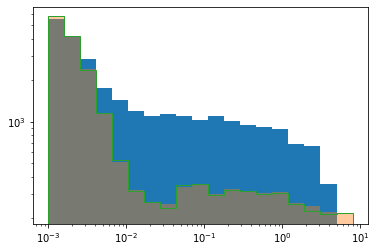

In [36]:
ebins = np.logspace(-3,np.log10(4),20)
ebins = np.logspace(-3,np.log10(8),20)
plt.hist(ldmx_photons[:,0],bins=ebins)

plt.hist(ldmx_photons_8GeV[:,0],bins=ebins,alpha=0.4)
Nboots = 100000
plt.hist(bootstrap_sample(ldmx_photons_8GeV, Nboots)[:,0],weights=np.ones(Nboots)*len(ldmx_photons_8GeV)/Nboots,bins=ebins,histtype='step')
plt.xscale('log')
plt.yscale('log')

In [11]:
len(ldmx_photons[ldmx_photons[:,0] > 1e-1])/len(ldmx_photons), len(ldmx_photons_8GeV[ldmx_photons_8GeV[:,0] > 2e-1])/len(ldmx_photons_8GeV)

(0.11970231648090562, 0.04462141322209581)

In [4]:
len(ldmx_photons_8GeV[ldmx_photons_8GeV[:,0] > 5e-2])

3078

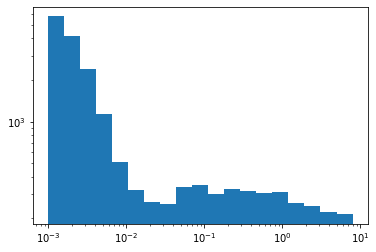

In [12]:
ebins = np.logspace(-3,np.log10(8),20)
plt.hist(ldmx_photons_8GeV[:,0],bins=ebins)
plt.xscale('log')
plt.yscale('log')

# Producing the Sample

In [15]:
"""
Generate events using the low energy sample
"""
ma_list = [0.01, 0.05, 0.1, 0.15, 0.2]
#ma_list = [0.1]
A = 183.84
Z = 74 #Tungsten

mN = 183.84 * 0.9314941 #For W, GeV


N_mcpN = 10000 # actual number of pN collisions simulated
N_photon_subset = 20000 # number of photons to use to speed up calculation of cross-section
direct_events = []
xsec_list = []
for ma in ma_list:
    out_dir_name = "../primakoff_events_4_GeV/"+"m_" + str(int(np.floor(ma*1000.)))
    out_lhe_fname = "unweighted_events.lhe"
    #os.mkdir(out_dir_name)
    
    # cross-section and width computed for a fiducial value the coupling
    width = alp_width(ma, 1e-3)
    ctau = hbarc/width
    
    result_dict = {}
    result_dict['ma'] = ma
    result_dict['tau'] = ctau
    result_dict['sigma'] = direct_production_cross_section(N_mcpN*len(ldmx_photons[:N_photon_subset])/len(ldmx_photons), ldmx_photons[:N_photon_subset], ma, mN, A, Z)
    result_dict['events'] = generate_primakoff_events(ldmx_photons, ma, mN, A, Z,tau, small_t_cut_over_t0=1000, print_output = True)
    direct_events.append(result_dict)
    xsec_list.append([ma, result_dict['sigma']['sigma']])
    
    run_info_str = "<runinfo>" + "\n" \
             + "# Primakoff process: gamma N > a N\n" \
             + "# ALP Mass [GeV] = " + str(ma) + "\n" \
             + "# ALP width [GeV] (for gag = 1e-3/GeV) = " + str(width) + "\n" \
             + "# ALP decay length [cm] " + str(ctau) + "\n" \
             + "# Nucleus Mass [GeV]= " + str(mN) + "\n" \
             + "# Nucleus A = " + str(A) + "\n" \
             + "# Nucleus Z = " + str(Z) + "\n" \
             + "# ALP decay time stored in the vtim (same units as decay length) entry of the record; use this to reconstruct vertex." + "\n" \
             + "# Number of Events: " + str(len(result_dict['events'])) + "\n" \
             + "# Integrated weight (for gag = 1e-3/GeV) [pb] : "+str(result_dict['sigma']['sigma']*1e36*1e-6) + "\n" + "</runinfo>" + "\n"
    #create_LHE_file(ma, mN, result_dict['events'], out_dir_name+"/"+out_lhe_fname, header_str = run_info_str)
xsec_list = np.array(xsec_list)

This took me 0.407492466767629 minutes to process 57242 events


In [13]:
"""
Generate events using the high-energy sample
"""
ma_list = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
#ma_list = [0.1]
A = 183.84
Z = 74 #Tungsten

mN = 183.84 * 0.9314941 #For W, GeV


N_mcpN = 10000 # actual number of pN collisions simulated
N_photon_subset = len(ldmx_photons_8GeV) #20000 # number of photons to use to speed up calculation of cross-section
direct_events = []
xsec_list_8_GeV = []
for ma in ma_list:
    out_dir_name = "../primakoff_events_8_GeV/"+"m_" + str(int(np.floor(ma*1000.)))
    out_lhe_fname = "unweighted_events.lhe"
    os.mkdir(out_dir_name)
    
    # cross-section and width computed for a fiducial value the coupling
    width = alp_width(ma, 1e-3)
    ctau = hbarc/width
    
    result_dict = {}
    result_dict['ma'] = ma
    result_dict['tau'] = ctau
    result_dict['sigma'] = direct_production_cross_section(N_mcpN*len(ldmx_photons_8GeV[:N_photon_subset])/len(ldmx_photons_8GeV), ldmx_photons_8GeV[:N_photon_subset], ma, mN, A, Z)
    result_dict['events'] = generate_primakoff_events(ldmx_photons_8GeV, ma, mN, A, Z,tau, small_t_cut_over_t0=1000, print_output = True)
    direct_events.append(result_dict)
    xsec_list_8_GeV.append([ma, result_dict['sigma']['sigma']])
    run_info_str = "<runinfo>" + "\n" \
             + "# Primakoff process: gamma N > a N\n" \
             + "# ALP Mass [GeV] = " + str(ma) + "\n" \
             + "# ALP width [GeV] (for gag = 1e-3/GeV) = " + str(width) + "\n" \
             + "# ALP decay length [cm] " + str(ctau) + "\n" \
             + "# Nucleus Mass [GeV]= " + str(mN) + "\n" \
             + "# Nucleus A = " + str(A) + "\n" \
             + "# Nucleus Z = " + str(Z) + "\n" \
             + "# ALP decay time stored in the vtim (same units as decay length) entry of the record; use this to reconstruct vertex." + "\n" \
             + "# Number of Events: " + str(len(result_dict['events'])) + "\n" \
             + "# Integrated weight (for gag = 1e-3/GeV) [pb] : "+str(result_dict['sigma']['sigma']*1e36*1e-6) + "\n" + "</runinfo>" + "\n"
    print(run_info_str)
    create_LHE_file(ma, mN, result_dict['events'], out_dir_name+"/"+out_lhe_fname, header_str = run_info_str)
xsec_list_8_GeV = np.array(xsec_list_8_GeV)

This took me 0.12633628050486248 minutes to process 47466 events


In [9]:
"""
Generate events using the high-energy sample but boot-strap to have larger statistics
Nboots samples will be generated, regardless of the actual number of viable photons in the original photon sample.
"""
ma_list = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
#ma_list = [0.1]
A = 183.84
Z = 74 #Tungsten

mN = 183.84 * 0.9314941 #For W, GeV
hbarc = 1.97327e-14 # GeV cm


N_mcpN = 10000 # actual number of pN collisions simulated
N_photon_subset = len(ldmx_photons_8GeV) #20000 # number of photons to use to speed up calculation of cross-section

Nboots = 100000 # number of samples to generate

direct_events = []
xsec_list_8_GeV = []
for ma in ma_list:
    out_dir_name = "../primakoff_events_8_GeV/"+"m_" + str(int(np.floor(ma*1000.)))
    out_lhe_fname = "unweighted_events.lhe"
    os.mkdir(out_dir_name)
    
    # cross-section and width computed for a fiducial value the coupling
    width = alp_width(ma, 1e-3)
    ctau = hbarc/width
    
    result_dict = {}
    result_dict['ma'] = ma
    result_dict['tau'] = ctau
    result_dict['sigma'] = direct_production_cross_section(N_mcpN*len(ldmx_photons_8GeV[:N_photon_subset])/len(ldmx_photons_8GeV), ldmx_photons_8GeV[:N_photon_subset], ma, mN, A, Z)
    
    # pick photons that can actually produce an ALP
    photon_mask = ldmx_photons_8GeV[:,0] > (ma**2 + 2.*ma*mN)/(2.*mN)
    viable_photons = ldmx_photons_8GeV[photon_mask]
    bootstrapped_viable_photons = bootstrap_sample(viable_photons, Nboots)
    
    result_dict['events'] = generate_primakoff_events_in_parallel(bootstrapped_viable_photons,ma, mN, A, Z,ctau, small_t_cut_over_t0=1000, print_output = True)
    direct_events.append(result_dict)
    xsec_list_8_GeV.append([ma, result_dict['sigma']['sigma']])
    run_info_str = "<runinfo>" + "\n" \
             + "# Primakoff process: gamma N > a N\n" \
             + "# ALP Mass [GeV] = " + str(ma) + "\n" \
             + "# ALP width [GeV] (for gag = 1e-3/GeV) = " + str(width) + "\n" \
             + "# ALP decay length [cm] " + str(ctau) + "\n" \
             + "# Nucleus Mass [GeV]= " + str(mN) + "\n" \
             + "# Nucleus A = " + str(A) + "\n" \
             + "# Nucleus Z = " + str(Z) + "\n" \
             + "# ALP decay time stored in the vtim (same units as decay length) entry of the record; use this to reconstruct vertex." + "\n" \
             + "# Number of Events: " + str(len(result_dict['events'])) + "\n" \
             + "# Integrated weight (for gag = 1e-3/GeV) [pb] : "+str(result_dict['sigma']['sigma']*1e36*1e-6) + "\n" + "</runinfo>" + "\n"
    print(run_info_str)
    create_LHE_file(ma, mN, result_dict['events'], out_dir_name+"/"+out_lhe_fname, header_str = run_info_str)
xsec_list_8_GeV = np.array(xsec_list_8_GeV)

100%|██████████| 100000/100000 [01:27<00:00, 1140.69it/s]


<runinfo>
# Primakoff process: gamma N > a N
# ALP Mass [GeV] = 0.01
# ALP width [GeV] (for gag = 1e-3/GeV) = 4.97359197162173e-15
# ALP decay length [cm] 3.9674947427514438
# Nucleus Mass [GeV]= 171.245875344
# Nucleus A = 183.84
# Nucleus Z = 74
# ALP decay time stored in the vtim (same units as decay length) entry of the record; use this to reconstruct vertex.
# Number of Events: 100000
# Integrated weight (for gag = 1e-3/GeV) [pb] : 6094.6959616705
</runinfo>



100%|██████████| 100000/100000 [01:57<00:00, 853.30it/s]


<runinfo>
# Primakoff process: gamma N > a N
# ALP Mass [GeV] = 0.05
# ALP width [GeV] (for gag = 1e-3/GeV) = 6.216989964527163e-13
# ALP decay length [cm] 0.031739957942011544
# Nucleus Mass [GeV]= 171.245875344
# Nucleus A = 183.84
# Nucleus Z = 74
# ALP decay time stored in the vtim (same units as decay length) entry of the record; use this to reconstruct vertex.
# Number of Events: 100000
# Integrated weight (for gag = 1e-3/GeV) [pb] : 2852.0273344268144
</runinfo>



100%|██████████| 100000/100000 [02:25<00:00, 687.27it/s]


<runinfo>
# Primakoff process: gamma N > a N
# ALP Mass [GeV] = 0.1
# ALP width [GeV] (for gag = 1e-3/GeV) = 4.9735919716217305e-12
# ALP decay length [cm] 0.003967494742751443
# Nucleus Mass [GeV]= 171.245875344
# Nucleus A = 183.84
# Nucleus Z = 74
# ALP decay time stored in the vtim (same units as decay length) entry of the record; use this to reconstruct vertex.
# Number of Events: 100000
# Integrated weight (for gag = 1e-3/GeV) [pb] : 1533.6101010431466
</runinfo>



100%|██████████| 100000/100000 [02:54<00:00, 572.21it/s]


<runinfo>
# Primakoff process: gamma N > a N
# ALP Mass [GeV] = 0.15
# ALP width [GeV] (for gag = 1e-3/GeV) = 1.6785872904223332e-11
# ALP decay length [cm] 0.0011755539978522802
# Nucleus Mass [GeV]= 171.245875344
# Nucleus A = 183.84
# Nucleus Z = 74
# ALP decay time stored in the vtim (same units as decay length) entry of the record; use this to reconstruct vertex.
# Number of Events: 100000
# Integrated weight (for gag = 1e-3/GeV) [pb] : 954.252284924337
</runinfo>



100%|██████████| 100000/100000 [03:17<00:00, 505.49it/s]


<runinfo>
# Primakoff process: gamma N > a N
# ALP Mass [GeV] = 0.2
# ALP width [GeV] (for gag = 1e-3/GeV) = 3.9788735772973844e-11
# ALP decay length [cm] 0.0004959368428439304
# Nucleus Mass [GeV]= 171.245875344
# Nucleus A = 183.84
# Nucleus Z = 74
# ALP decay time stored in the vtim (same units as decay length) entry of the record; use this to reconstruct vertex.
# Number of Events: 100000
# Integrated weight (for gag = 1e-3/GeV) [pb] : 634.9741683562166
</runinfo>



100%|██████████| 100000/100000 [03:37<00:00, 459.36it/s]


<runinfo>
# Primakoff process: gamma N > a N
# ALP Mass [GeV] = 0.3
# ALP width [GeV] (for gag = 1e-3/GeV) = 1.3428698323378666e-10
# ALP decay length [cm] 0.00014694424973153502
# Nucleus Mass [GeV]= 171.245875344
# Nucleus A = 183.84
# Nucleus Z = 74
# ALP decay time stored in the vtim (same units as decay length) entry of the record; use this to reconstruct vertex.
# Number of Events: 100000
# Integrated weight (for gag = 1e-3/GeV) [pb] : 311.1820365667905
</runinfo>



100%|██████████| 100000/100000 [04:38<00:00, 358.77it/s]


<runinfo>
# Primakoff process: gamma N > a N
# ALP Mass [GeV] = 0.4
# ALP width [GeV] (for gag = 1e-3/GeV) = 3.1830988618379075e-10
# ALP decay length [cm] 6.19921053554913e-05
# Nucleus Mass [GeV]= 171.245875344
# Nucleus A = 183.84
# Nucleus Z = 74
# ALP decay time stored in the vtim (same units as decay length) entry of the record; use this to reconstruct vertex.
# Number of Events: 100000
# Integrated weight (for gag = 1e-3/GeV) [pb] : 163.41686468655308
</runinfo>



100%|██████████| 100000/100000 [03:55<00:00, 423.77it/s]


<runinfo>
# Primakoff process: gamma N > a N
# ALP Mass [GeV] = 0.5
# ALP width [GeV] (for gag = 1e-3/GeV) = 6.216989964527161e-10
# ALP decay length [cm] 3.173995794201156e-05
# Nucleus Mass [GeV]= 171.245875344
# Nucleus A = 183.84
# Nucleus Z = 74
# ALP decay time stored in the vtim (same units as decay length) entry of the record; use this to reconstruct vertex.
# Number of Events: 100000
# Integrated weight (for gag = 1e-3/GeV) [pb] : 88.78401355031755
</runinfo>



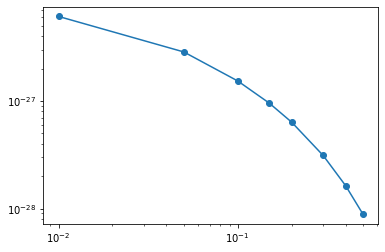

In [10]:
#plt.plot(xsec_list[:,0],xsec_list[:,1])
plt.plot(xsec_list_8_GeV[:,0],xsec_list_8_GeV[:,1],'-o')
plt.xscale('log')
plt.yscale('log')

## Sanity Checks of Generated Events

(1e-05, 1)

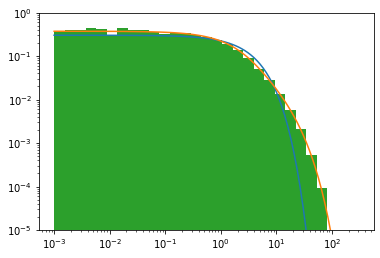

In [50]:
# Consistency check: distribution of decay times matches expectation
bins = np.logspace(-3,np.log10(300),30)
t_over_ctau_list = np.logspace(-3,np.log10(300),100)

gammas = result_dict['events'][:,1,0]/ma
gamma_mean = np.mean(gammas)
gamma_mean = np.median(gammas)

plt.plot(t_over_ctau_list, np.exp(-t_over_ctau_list/gamma_mean)/(gamma_mean))
plt.plot(t_over_ctau_list, [np.mean(np.exp(-t_over_ctau/gammas)/(gammas)) for t_over_ctau in t_over_ctau_list])
plt.hist(result_dict['events'][:,5,0]/ctau,bins=bins,density=True)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-5,1])

(array([0.26344624, 0.11620019, 0.0656398 , 0.05410849, 0.04789932,
        0.02661073, 0.01951454, 0.03193288, 0.01685346, 0.02749776]),
 array([ 1.00013123,  2.49332953,  3.98652783,  5.47972614,  6.97292444,
         8.46612274,  9.95932104, 11.45251935, 12.94571765, 14.43891595,
        15.93211426]),
 <BarContainer object of 10 artists>)

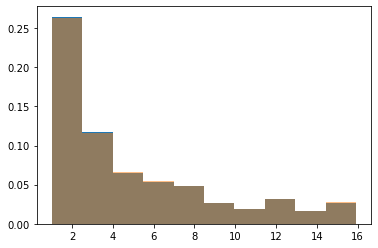

In [35]:
# Consistency check: distribution of boost factors matches expectation from Primakoff kinematics (ALP inherits photon energy)
plt.hist(result_dict['events'][:,1,0]/ma,density=True)
mask = ldmx_photons_8GeV[:,0] > ma
plt.hist(ldmx_photons_8GeV[mask][:,0]/ma,density=True,alpha=0.5)